<div class="plm">
<font color=black> <font size=6> **Mock Project: Patients Like Me** <br>
    
<font color=#205A6B> <font size=5> **Candidate Details:**<br>
<font color=#205A6B> <font size=4> 
Name: Suhail Khan <br>
Email ID: ksuhail49@gmail.com <br>
Phone: +1 651-366-0707 <br>
</div>

<p class="h3"> <a href="http://167.71.144.110/">Click to access the webapp</a>


<p class="h3"> <a href="https://github.com/isuhail/PatientsLikeMe">Link to Webapp code base</a>


# <center> Table of Contents <center>

***
**Section 1: Import Libraries/Dependencies and Take User Input**

***
**Section 2: Data preprocessing and Exploratory Data Analysis**

    A. Preprocessing functions
    B. Dataset Summary
    C. Aggregating the symptoms and conditions for each user and preparing a dataset for NLP
    
***
**Section 3: Natural Language processing pipeline and LDA Implementation**

    A. Removing Special characters
    B. Tokenize
    C. Lemmatize
    D. Encoding Data using count vectorizer
    E. Fit the model
    F. GridsearchCV to get the best hyperparameters
    G. Generate the topics using the best model
    H. Run the entire pipeline to predict the topics from the training dataset
    
***
**Section 4: Generate the trend for the variation of ALS Score over time for users in different topics**

    A. Merge the score data with the previously obtained topic labelled data
    B. Split the dataset topicwise and generate time series trends


# <center> Section 1: Import Libraries/Dependencies and Take User Input <center>

In [2]:
import pandas as pd
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 

In [3]:
pd.options.display.max_rows = 150
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

C:\Users\ksuha\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [4]:
score=pd.read_csv('user_ALSFRS_score.csv')

In [5]:
condition=pd.read_csv('user_condition.csv')

In [6]:
date=pd.read_csv('user_onset_date.csv')

In [7]:
symptom=pd.read_csv('user_symptom.csv')

# <center> Section 2: Data Preprocessing and Exploratory Data Analysis <center>

## A. Preprocessing functions

In [458]:
def dataset_summary(df_raw):
    # Check the rows and columns
    r, c = df_raw.shape
    print('Total Rows: {0} ; Total Columns: {1}'.format(r,c) )
    print('\n')

    numerical_feats = df_raw.dtypes[df_raw.dtypes != "object"].index
    print("Number of Categorical features: ", len(numerical_feats))
    #print('\n')

    categorical_feats = df_raw.dtypes[df_raw.dtypes == "object"].index
    print("Number of Numerical features: ", len(categorical_feats))

    print('Column Names: \n')
    print(df_raw.columns)
    
    print('Data Type Analysis: \n')
    df_dtype=df_raw.dtypes
    #df_dtype.rename(columns={0: "Attribute", 1: "Data Type"})
    df_dtype=df_dtype.to_frame().reset_index()
    df_dtype.columns=['Attribute','Data Type'] 
    print(df_dtype)

In [459]:
def missing_values_graph(dataset,total):
    
    # STEP 1: Tabular View
    df_raw=dataset
    all_data_na = (df_raw.isnull().sum() / len(df_raw)) * 100
    #NOTE: .isna check also yeilds the same atttribute ranking for airbnb
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:total]
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    #missing_data.head(5)

    # STEP 2: Graphical view
    
    #Set font settings
    sns.set(style="white",font_scale=1)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']
    # Set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    
    f, ax = plt.subplots(figsize=(10, 6)) #,facecolor='ivory'
    plt.bar(all_data_na.index,all_data_na,color = 'teal', alpha = 0.55,edgecolor = "black")
    plt.xticks(rotation='90')
    #adds major gridlines
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    # Remove plot frame
    ax.set_frame_on(False)
    # We change the fontsize of major ticks label 
    param_size=8
    if total>40:
        param_size=8
    elif total<=40:
        param_size=13
    
    ax.tick_params(axis='both', which='major', labelsize=param_size)
    plt.yticks(fontsize=13)
    plt.xlabel('Features', fontsize=13,fontweight='bold') 
    plt.ylabel('Percent of missing values', fontsize=13,fontweight='bold')
    plt.title('Missing Data (in %)', fontsize=13,fontweight='bold')
    fig1 = plt.gcf()
    plt.show()

## B. Dataset Summary

In [460]:
dataset_summary(score)

Total Rows: 4409 ; Total Columns: 3


Number of Categorical features:  2
Number of Numerical features:  1
Column Names: 

Index(['user_id', 'report_date', 'score'], dtype='object')
Data Type Analysis: 

     Attribute Data Type
0  user_id      int64   
1  report_date  object  
2  score        int64   


In [11]:
score.user_id.value_counts()

2579    78
2759    70
2520    62
521     60
5366    59
5706    59
436     52
3806    51
6436    51
2917    49
1189    49
4952    47
788     47
3805    46
2856    44
2133    44
6180    41
800     41
2050    40
1960    40
230     39
724     38
417     37
2703    37
5011    37
6900    35
985     35
2281    34
3550    33
5009    32
1361    32
1097    32
6272    31
2077    31
5993    31
6654    31
997     30
4887    29
5081    29
3858    29
5245    29
6701    29
3893    29
6452    29
7188    28
1816    28
5820    28
7344    27
782     27
544     27
7483    26
7423    26
3895    26
7233    26
1702    26
2019    26
5489    26
2514    25
350     25
5636    25
6562    25
4427    25
1841    24
6788    24
4237    24
6813    24
3624    24
4417    23
4053    23
6161    23
4161    23
4740    22
3873    22
193     22
4322    22
1425    21
6320    21
3880    21
5589    21
7087    20
7326    20
3439    20
3327    20
4561    19
525     19
75      19
4928    19
6061    19
5085    19
5173    19
7150    18

In [12]:
score.user_id.nunique()

200

In [461]:
dataset_summary(date)

Total Rows: 229 ; Total Columns: 3


Number of Categorical features:  2
Number of Numerical features:  1
Column Names: 

Index(['Unnamed: 0', 'user_id', 'first_definitive_diagnosis_date'], dtype='object')
Data Type Analysis: 

                         Attribute Data Type
0  Unnamed: 0                       int64   
1  user_id                          int64   
2  first_definitive_diagnosis_date  object  


In [14]:
date.head()

,Unnamed: 0,user_id,first_definitive_diagnosis_date
0,0,4941,2008-01-01
1,1,5814,2004-06-01
2,2,6161,2007-03-01
3,3,1702,2006-02-01
4,4,43,1999-08-01


In [15]:
date.user_id.nunique()

229

In [462]:
dataset_summary(symptom)

Total Rows: 261716 ; Total Columns: 3


Number of Categorical features:  2
Number of Numerical features:  1
Column Names: 

Index(['user_id', 'symptom_name', 'symptom_severity_score'], dtype='object')
Data Type Analysis: 

                Attribute Data Type
0  user_id                 int64   
1  symptom_name            object  
2  symptom_severity_score  float64 


In [17]:
symptom.head()

,Unnamed: 0,user_id,symptom_name,symptom_severity_score
0,0,43943,TMJ (temporomandibular joint) pain,1.0
1,1,146585,atrophy of right hand muscles,4.0
2,2,146585,pain in right hand,1.0
3,3,146585,slow speech (bradyarthria),3.0
4,4,146585,stiffness in right leg,4.0


In [18]:
symptom.user_id.nunique()

35912

In [19]:
symptom.symptom_name.nunique()

6538

In [463]:
dataset_summary(condition)

Total Rows: 626914 ; Total Columns: 2


Number of Categorical features:  1
Number of Numerical features:  1
Column Names: 

Index(['user_id', 'condition_name'], dtype='object')
Data Type Analysis: 

        Attribute Data Type
0  user_id         int64   
1  condition_name  object  


In [21]:
condition.user_id.nunique()

435861

In [22]:
condition.condition_name.nunique()

20

In [23]:
condition.condition_name.value_counts()

fibromyalgia                                          114041
multiple sclerosis                                    68615 
major depressive disorder                             61083 
generalized anxiety disorder                          41497 
bipolar disorder                                      39462 
diabetes type 2                                       37916 
systemic lupus erythematosus                          37842 
post-traumatic stress disorder                        32821 
rheumatoid arthritis                                  28408 
Parkinson's disease                                   26615 
high blood pressure (hypertension)                    18885 
panic disorder                                        18596 
myalgic encephalomyelitis/chronic fatigue syndrome    18260 
persistent depressive disorder (dysthymia)            13207 
amyotrophic lateral sclerosis                         13118 
migraine                                              11850 
epilepsy                

In [24]:
condition.head()

,Unnamed: 0,user_id,condition_name
0,0,44386,generalized anxiety disorder
1,1,363068,fibromyalgia
2,2,363068,rheumatoid arthritis
3,3,363068,systemic lupus erythematosus
4,4,43943,fibromyalgia


## C. Aggregating the symptoms and conditions for each user and preparing a dataset for NLP

In [188]:
symptom=symptom[['user_id','symptom_name','symptom_severity_score']]

In [189]:
symptom.head()

,user_id,symptom_name,symptom_severity_score
0,43943,TMJ (temporomandibular joint) pain,1.0
1,146585,atrophy of right hand muscles,4.0
2,146585,pain in right hand,1.0
3,146585,slow speech (bradyarthria),3.0
4,146585,stiffness in right leg,4.0


In [190]:
symptom1=symptom[['user_id','symptom_name']]

In [191]:
symptom2=symptom[['user_id','symptom_severity_score']]

In [192]:
symp=symptom[['user_id']]

In [193]:
symp.head()

,user_id
0,43943
1,146585
2,146585
3,146585
4,146585


In [475]:
cd=condition.groupby('user_id',as_index=False,sort=False).agg(','.join)

In [476]:
cd.shape

(435861, 2)

In [203]:
st=symptom1.groupby('user_id',as_index=False,sort=False).agg(','.join)

In [316]:
st.head()

,user_id,symptom_name
0,43943,TMJ (temporomandibular joint) pain
1,146585,"atrophy of right hand muscles,pain in right hand,slow speech (bradyarthria),stiffness in right leg,weakness in right leg"
2,407374,"heat intolerance,numbness and tingling with pins and needles"
3,152774,TMJ (temporomandibular joint) pain
4,59097,"bad thoughts,fear of going insane,spacing out"


In [206]:
st.shape

(35912, 2)

In [208]:
sm=symptom2.groupby('user_id',as_index=False,sort=False).mean()

In [315]:
sm.head()

,user_id,symptom_severity_score
0,43943,1.000000
1,146585,3.200000
2,407374,2.000000
3,152774,1.000000
4,59097,2.666667


In [317]:
s3=pd.merge(st,sm,on='user_id')

In [318]:
s3.head()

,user_id,symptom_name,symptom_severity_score
0,43943,TMJ (temporomandibular joint) pain,1.000000
1,146585,"atrophy of right hand muscles,pain in right hand,slow speech (bradyarthria),stiffness in right leg,weakness in right leg",3.200000
2,407374,"heat intolerance,numbness and tingling with pins and needles",2.000000
3,152774,TMJ (temporomandibular joint) pain,1.000000
4,59097,"bad thoughts,fear of going insane,spacing out",2.666667


In [319]:
sc=pd.merge(s3,cd,on='user_id',how='left')

In [213]:
sc.shape

(35912, 4)

In [216]:
sc.condition_name.isna().sum()

3180

In [239]:
sc.symptom_name.nunique()

22105

In [241]:
sc.shape

(35912, 4)

In [244]:
sc.symptom_name=sc.symptom_name.str.replace(',',' ')

In [246]:
sc.head(10)

,user_id,symptom_name,symptom_severity_score,condition_name
0,43943,TMJ (temporomandibular joint) pain,1.000000,fibromyalgia
1,146585,atrophy of right hand muscles pain in right hand slow speech (bradyarthria) stiffness in right leg weakness in right leg,3.200000,amyotrophic lateral sclerosis
2,407374,heat intolerance numbness and tingling with pins and needles,2.000000,multiple sclerosis
3,152774,TMJ (temporomandibular joint) pain,1.000000,fibromyalgia
4,59097,bad thoughts fear of going insane spacing out,2.666667,"generalized anxiety disorder,major depressive disorder,persistent depressive disorder (dysthymia)"
5,30675,UTI symptoms bladder infection brain infection common cold ear infection eye infection herpes outbreak mouth/throat infection nose infection persistent cough pneumonia symptoms sexually transmitted disease (STD) shingles rash stomach infection/inflammation yeast infection (candida),1.600000,NaN
6,375283,burning sensation on left bottom wrist can't squeeze with left hand muscle twitching (fasciculations) in left thumb neck pain numbness pain in right eye pain in shoulder(s),3.142857,multiple sclerosis
7,88061,neck pain stiffness in neck,4.000000,NaN
8,95791,bad mood cutting (self injury) neuropathic pain in lower extremities,2.666667,"generalized anxiety disorder,major depressive disorder,osteoarthritis"
9,124990,bowel incontinence,1.000000,NaN


# <center> Section 3: Natural Language processing pipeline and LDA implementation <center>

### A. Removing special characters

In [469]:
import re
# Convert to list
data = sc.symptom_name.tolist()
# Remove Emails
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]
print(data[:1])

['TMJ (temporomandibular joint) pain']


### B. Tokenize

In [470]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:5])

[['tmj', 'joint', 'pain'], ['atrophy', 'of', 'right', 'hand', 'muscles', 'pain', 'in', 'right', 'hand', 'slow', 'speech', 'bradyarthria', 'stiffness', 'in', 'right', 'leg', 'weakness', 'in', 'right', 'leg'], ['heat', 'intolerance', 'numbness', 'and', 'tingling', 'with', 'pins', 'and', 'needles'], ['tmj', 'joint', 'pain'], ['bad', 'thoughts', 'fear', 'of', 'going', 'insane', 'spacing', 'out']]


### C. Lemmatize

In [410]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [411]:
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
#nlp = spacy.load(‘en_core_web_sm’, disable=[‘parser’, ‘ner’])
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words) #select noun and verb
print(data_lemmatized[:2])

['pain', 'right hand muscle pain right hand speech right leg weakness right leg']


In [298]:
data_lemmatized[1:10]

['right hand muscle pain right hand speech right leg weakness right leg',
 'heat intolerance numbness tingle pin needle',
 'pain',
 'bad thought fear go insane space',
 'infection brain infection common cold ear infection eye infection herpe infection persistent cough pneumonia symptom sexually transmit disease std shingle rash stomach infection inflammation yeast infection candida',
 'burn sensation left bottom wrist can squeeze left hand muscle twitching fasciculation left thumb neck pain numbness pain right eye pain shoulder',
 'pain stiffness neck',
 'bad mood cut self neuropathic pain low extremity',
 '']

In [302]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

### D. Encode the data using count vectorizer

In [303]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,
# minimum reqd occurences of a word 
                             stop_words='english',             
# remove stop words
                             lowercase=True,                   
# convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  
# num chars > 3
                             # max_features=50000,             
# max number of uniq words    )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [407]:
filename='vectorizer.pkl'
pickle.dump(vectorizer, open(filename, 'wb'))

### E. Fit the model

In [304]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [305]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2825700.0129710655
Perplexity:  207.92950710196519
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### F. GridsearchCV for the best hyper parameters

In [308]:
# Define Search Param
search_params = {'n_components': [5,10, 15], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
              perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       param_grid={'n_topics': [5, 10, 15], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method=None,
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=1,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_

In [309]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 15}
Best Log Likelihood Score:  -572325.3283687674
Model Perplexity:  196.1149910017413


### G. Generate the topics using the best model

In [311]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,dominant_topic
Doc0,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.530000,14
Doc1,0.010000,0.850000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.090000,1
Doc2,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.870000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,7
Doc3,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.530000,14
Doc4,0.230000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.600000,0.010000,0.010000,0.010000,0.010000,10
Doc5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.970000,0.000000,0.000000,0.000000,11
Doc6,0.000000,0.460000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320000,1
Doc7,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.770000,14
Doc8,0.250000,0.010000,0.010000,0.110000,0.340000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.220000,4
Doc9,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0


In [312]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

abdominal   ability  ablation   abnormal  abnormality    absence  \
Topic0  0.066688    0.066667  0.066667  0.066667   0.066667     75.987707   
Topic1  208.385749  0.066667  0.066667  16.425836  0.066681     0.066668    
Topic2  0.066667    0.066667  0.066667  0.066667   0.066667     0.066667    
Topic3  0.066667    0.066667  0.066667  0.066667   0.066667     0.066667    
Topic4  0.066667    0.066667  0.066667  34.953407  0.066667     0.066667    

           absent      abuse  accident  accomplish      ache  achiness  \
Topic0  0.066667   29.236064  0.066667  75.820667   0.066667  0.066667   
Topic1  0.066667   0.066667   0.066667  0.066667    0.084221  0.066667   
Topic2  0.066667   0.066667   0.066667  0.066667    0.066667  0.066667   
Topic3  0.066667   0.066667   0.066667  0.066667    0.066667  0.066667   
Topic4  33.737190  0.066667   0.066667  0.066667    0.066667  0.066667   

            acid   activity      acute  addiction  adhesive  adolescence  \
Topic0  0.066667  54.277551  0.066667   22.671898  0.066667  25.703894     
Topic1  0.066713  0.066667   0.066667   0.066667   0.066667  0.066667      
Topic2  0.066667  0.066667   0.066667   0.066667   0.066667  0.066667      
Topic3  0.066667  0.066667   0.066667   0.066667   0.066667  0.066667      
Topic4  0.066668  0.066667   21.248341  0.066667   0.066667  0.066747      

         adrenal    affect  affective  aggressive   agitation  agoraphobia  \
Topic0  0.066667  0.066667  29.803064  30.980230   249.323606  0.066679      
Topic1  0.066667  0.066667  0.066667   0.066667    0.066667    0.066667      
Topic2  0.066667  0.066667  0.066667   0.066667    0.066718    0.066667      
Topic3  0.066667  0.066667  0.066667   0.066667    0.066667    0.066667      
Topic4  0.066667  0.066667  0.066667   0.066667    0.066667    0.066667      

               aid     alcohol  allergic  allergie    allergy  allodynia  \
Topic0  0.066667    229.415280  0.066667  0.066667  11.759489  0.066667    
Topic1  372.921437  0.066667    0.066667  0.066667  0.066667   0.066667    
Topic2  0.066667    69.692508   0.066667  0.066667  0.066667   0.066667    
Topic3  0.066667    0.066667    0.066667  0.066667  0.066667   0.066667    
Topic4  0.066667    0.066667    0.066667  0.066667  0.066667   0.066667    

            alter  alternate  ambivalent  amenorrhea   amplify      anal  \
Topic0  17.421887  0.066667   0.066667    8.026759    0.066667  0.066667   
Topic1  0.066667   0.066667   0.066667    0.066667    0.069248  0.066667   
Topic2  0.066667   0.066667   0.066667    0.066667    0.066667  0.066667   
Topic3  0.066667   0.066667   0.066667    0.066667    0.066667  0.066667   
Topic4  0.066667   0.066667   0.066667    0.066667    0.066667  0.066667   

          anemia       anger      angry  anhedonia     ankle   annoyed  \
Topic0  0.066667  244.938222  62.046949  0.066668   0.066667  0.066667   
Topic1  0.066667  0.066667    0.066667   0.066667   0.066667  0.066667   
Topic2  0.066667  0.066667    0.066667   0.066667   0.066668  0.066667   
Topic3  0.066667  0.066667    0.066667   0.066667   0.066667  0.066667   
Topic4  0.066667  0.066667    0.066667   0.066667   0.066667  7.920585   

          anomia    anosmia    answer  anticipatory     anxiety     anxious  \
Topic0  0.066667  0.066667   0.066667  0.066667      714.467753  0.066667     
Topic1  0.075127  16.637992  0.066667  0.066667      27.584097   0.066667     
Topic2  0.066667  0.066667   0.066667  0.066667      0.066667    0.066667     
Topic3  0.066667  0.066667   0.066667  0.066667      0.066667    275.016638   
Topic4  0.066667  0.066667   0.066667  0.066667      0.066667    0.066667     

           apathy   aphthous      apnea  appendectomy   appetite  appointment  \
Topic0  28.435859  0.066667   0.066667   0.066667      27.531310  13.025554     
Topic1  0.066667   0.066667   17.746840  0.066667      0.066667   0.066667      
Topic2  0.066667   0.066667   0.066667   0.066667      0.066684   0.066667      
Topic3  0.066667 

In [313]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,self,thought,difficulty,lack,feeling,motivation,suicidal,social,urge,avoidance,anxiety,stress,think,irritability,loneliness
Topic 1,muscle,weakness,hand,loss,difficulty,arm,foot,tremor,cramp,leg,atrophy,left,right,problem,speech
Topic 2,idea,flight,thinking,excitability,grandiose,irritability,hallucination,paranoia,headache,light,speech,slow,sensitivity,bradyarthria,migraine
Topic 3,problem,mood,excessive,spasticity,emotional,bladder,sleepiness,lability,bowel,constipation,fog,swing,brain,daytime,excess
Topic 4,low,chest,spasm,fever,extremity,surgery,reaction,transplant,congestion,urine,kidney,disk,rejection,herniate,gallbladder
Topic 5,blood,pressure,deficiency,elevated,vitamin,high,eye,cholesterol,dry,heart,sleep,low,allergy,elevate,chronic
Topic 6,problem,vision,leg,difficulty,word,heat,lose,weakness,brain,train,numbness,fishing,thought,pain,intolerance
Topic 7,numbness,sensation,tingle,pin,needle,cold,burn,foot,leg,hand,eye,symptom,seizure,heat,intolerance
Topic 8,skin,body,facial,ache,hot,itch,flush,urination,muscle,skill,frequent,disorder,itchy,flash,seasonal
Topic 9,feel,dizziness,faint,hot,flash,vertigo,irregular,sweat,period,mental,night,menstrual,movement,excessive,ability


In [314]:
sc.head()

,user_id,symptom_name,symptom_severity_score,condition_name
0,43943,TMJ (temporomandibular joint) pain,1.000000,fibromyalgia
1,146585,atrophy of right hand muscles pain in right hand slow speech (bradyarthria) stiffness in right leg weakness in right leg,3.200000,amyotrophic lateral sclerosis
2,407374,heat intolerance numbness and tingling with pins and needles,2.000000,multiple sclerosis
3,152774,TMJ (temporomandibular joint) pain,1.000000,fibromyalgia
4,59097,bad thoughts fear of going insane spacing out,2.666667,"generalized anxiety disorder,major depressive disorder,persistent depressive disorder (dysthymia)"


In [487]:
Topics = ['Mental Health related issues',
 'Body part/muscle pain','Headache/Speech issues',
 'Spasticity/ digestive issues',
 'Chest pain/hernia/ urination problems',
 'Blood pressure and heart problems',
 'Neurological/ vision and speech related issues',
 'Sensitivity issues',
 'Skin problems','Body balance/menstrual problems','Emotional issues','Infections/ excessive fat issues','Sore throat/ abdominal problems', 'Sleep related problems', 'Joint/neck pain'
]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,self,thought,difficulty,lack,feeling,motivation,suicidal,social,urge,avoidance,anxiety,stress,think,irritability,loneliness,Mental Health related issues
Topic 1,muscle,weakness,hand,loss,difficulty,arm,foot,tremor,cramp,leg,atrophy,left,right,problem,speech,Body part/muscle pain
Topic 2,idea,flight,thinking,excitability,grandiose,irritability,hallucination,paranoia,headache,light,speech,slow,sensitivity,bradyarthria,migraine,Headache/Speech issues
Topic 3,problem,mood,excessive,spasticity,emotional,bladder,sleepiness,lability,bowel,constipation,fog,swing,brain,daytime,excess,Spasticity/ digestive issues
Topic 4,low,chest,spasm,fever,extremity,surgery,reaction,transplant,congestion,urine,kidney,disk,rejection,herniate,gallbladder,Chest pain/hernia/ urination problems
Topic 5,blood,pressure,deficiency,elevated,vitamin,high,eye,cholesterol,dry,heart,sleep,low,allergy,elevate,chronic,Blood pressure and heart problems
Topic 6,problem,vision,leg,difficulty,word,heat,lose,weakness,brain,train,numbness,fishing,thought,pain,intolerance,Neurological/ vision and speech related issues
Topic 7,numbness,sensation,tingle,pin,needle,cold,burn,foot,leg,hand,eye,symptom,seizure,heat,intolerance,Sensitivity issues
Topic 8,skin,body,facial,ache,hot,itch,flush,urination,muscle,skill,frequent,disorder,itchy,flash,seasonal,Skin problems
Topic 9,feel,dizziness,faint,hot,flash,vertigo,irregular,sweat,period,mental,night,menstrual,movement,excessive,ability,Body balance/menstrual problems


### H. Run the entire pipeline to predict the topics from the training dataset

In [488]:
# Define function to predict topic for a given text document.
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def predict_topic(text):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
# Predict the topic
mytext = [" HIV related neurological symptoms,HIV-related arthritis,UTI symptoms,anemia,bladder infection,brain infection,common cold,ear infection,eye infection,growths or tumors (dysplasia),herpes outbreak,lipodystrophy (lipoatrophy or loss of fatty tissue),mouth sores (ulcers),mouth/throat infection,nose infection,peripheral neuritis,persistent cough,pneumonia symptoms,sexually transmitted disease (STD),shingles rash,stomach infection/inflammation,yeast infection (candida)"]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

['symptom', 'related', 'mouth', 'inflammation', 'peripheral', 'rash', 'loss', 'stomach', 'shingle', 'arthritis', 'neurological', 'tissue', 'fatty']
Infections/ excessive fat issues


In [334]:
def apply_predict_topic(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)
sc["Topic_key_word"]= sc['symptom_name'].apply(apply_predict_topic)
sc.head()

,user_id,symptom_name,symptom_severity_score,condition_name,Topic_key_word
0,43943,TMJ (temporomandibular joint) pain,1.000000,fibromyalgia,Joint pain(arthritis)
1,146585,"atrophy of right hand muscles,pain in right hand,slow speech (bradyarthria),stiffness in right leg,weakness in right leg",3.200000,amyotrophic lateral sclerosis,Body pain
2,407374,"heat intolerance,numbness and tingling with pins and needles",2.000000,multiple sclerosis,Sensitivity issues
3,152774,TMJ (temporomandibular joint) pain,1.000000,fibromyalgia,Joint pain(arthritis)
4,59097,"bad thoughts,fear of going insane,spacing out",2.666667,"generalized anxiety disorder,major depressive disorder,persistent depressive disorder (dysthymia)",Emotional issues


In [335]:
sc.to_csv('output.csv')

In [337]:
import pickle

In [401]:
filename = 'finalized_model.pkl'
pickle.dump(best_lda_model, open(filename, 'wb'))

In [339]:
df_topic_keywords.to_csv('topic_keywords.csv')

In [342]:
sc.Topic_key_word.value_counts()

Joint pain(arthritis)                             8089
Body pain                                         4457
Mental Health related issues                      4153
Sensitivity issues                                3284
Neurological/ vision and speech related issues    3036
Blood pressure and heart problems                 2030
Sleep related problems                            1881
Headache/Speech issues                            1819
Sore throat/ abdominal problems                   1340
Emotional issues                                  1321
Spasticity/ digestive issues                      1219
Infections/ excessive fat issues                  1077
Body balance/menstrual problems                   974 
Chest pain/hernia/ urination problems             678 
Skin problems                                     554 
Name: Topic_key_word, dtype: int64

# <center> Section4 : Generate the trend for the variation of ALS Score over time for users in different topics  <center>

## A.Merge the score data with the previously obtained topic labelled data

In [344]:
score=score[['user_id','report_date','score']]

In [345]:
score.head()

,user_id,report_date,score
0,2520,2005-08-05,36
1,2520,2002-01-04,44
2,2520,2006-12-08,28
3,2520,2006-08-04,29
4,2520,2007-04-13,29


In [471]:
ts=pd.merge(score,sc, on='user_id',how='left')

In [472]:
ts.head()

,user_id,report_date,score,symptom_name,symptom_severity_score,condition_name,Topic_key_word
0,2520,2005-08-05,36,NaN,NaN,NaN,NaN
1,2520,2002-01-04,44,NaN,NaN,NaN,NaN
2,2520,2006-12-08,28,NaN,NaN,NaN,NaN
3,2520,2006-08-04,29,NaN,NaN,NaN,NaN
4,2520,2007-04-13,29,NaN,NaN,NaN,NaN


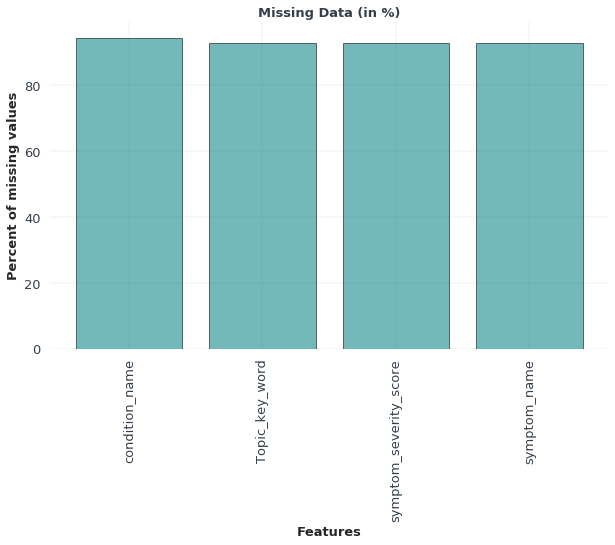

In [350]:
Missing_Values_Graph(ts,10)

In [354]:
ts.symptom_name.isna().sum()

4095

In [473]:
ts.shape

(4409, 7)

In [359]:
ts1=ts[ts.symptom_name.notnull()]

In [361]:
ts1.shape

(314, 7)

In [362]:
ts1.Topic_key_word.value_counts()

Mental Health related issues                      85
Neurological/ vision and speech related issues    64
Joint pain(arthritis)                             42
Sensitivity issues                                28
Body pain                                         25
Sleep related problems                            24
Chest pain/hernia/ urination problems             18
Spasticity/ digestive issues                      16
Sore throat/ abdominal problems                   12
Name: Topic_key_word, dtype: int64

In [378]:
ts1['report_date'] = ts1['report_date'].astype('datetime64[ns]')

C:\Users\ksuha\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## B.Split the dataset topicwise and generate time series trends

In [380]:
ts11=ts1[ts1.Topic_key_word == 'Mental Health related issues']

In [381]:
ts11.head()

,user_id,report_date,score,symptom_name,symptom_severity_score,condition_name,Topic_key_word
1796,6272,2010-10-31,11,"irritability,rage,uncontrollable crying",2.666667,"major depressive disorder,persistent depressive disorder (dysthymia),post-traumatic stress disorder",Mental Health related issues
1797,6272,2009-05-12,20,"irritability,rage,uncontrollable crying",2.666667,"major depressive disorder,persistent depressive disorder (dysthymia),post-traumatic stress disorder",Mental Health related issues
1798,6272,2010-11-30,10,"irritability,rage,uncontrollable crying",2.666667,"major depressive disorder,persistent depressive disorder (dysthymia),post-traumatic stress disorder",Mental Health related issues
1799,6272,2009-12-28,13,"irritability,rage,uncontrollable crying",2.666667,"major depressive disorder,persistent depressive disorder (dysthymia),post-traumatic stress disorder",Mental Health related issues
1800,6272,2009-03-02,28,"irritability,rage,uncontrollable crying",2.666667,"major depressive disorder,persistent depressive disorder (dysthymia),post-traumatic stress disorder",Mental Health related issues


In [382]:
ts12=ts1[ts1.Topic_key_word == 'Neurological/ vision and speech related issues']
ts13=ts1[ts1.Topic_key_word == 'Joint pain(arthritis)']
ts14=ts1[ts1.Topic_key_word == 'Sensitivity issues']
ts15=ts1[ts1.Topic_key_word == 'Body pain']
ts16=ts1[ts1.Topic_key_word == 'Sleep related problems']
ts17=ts1[ts1.Topic_key_word == 'Chest pain/hernia/ urination problems']
ts18=ts1[ts1.Topic_key_word == 'Spasticity/ digestive issues']
ts19=ts1[ts1.Topic_key_word == 'Sore throat/ abdominal problems']

In [389]:
tts1=ts11[['report_date','score']]
tts2=ts12[['report_date','score']]
tts3=ts13[['report_date','score']]
tts4=ts14[['report_date','score']]
tts5=ts15[['report_date','score']]
tts6=ts16[['report_date','score']]
tts7=ts17[['report_date','score']]
tts8=ts18[['report_date','score']]
tts9=ts19[['report_date','score']]

In [384]:
tts1.dtypes

report_date    datetime64[ns]
score          int64         
dtype: object

In [390]:
tts1.head()

,report_date,score
1796,2010-10-31,11
1797,2009-05-12,20
1798,2010-11-30,10
1799,2009-12-28,13
1800,2009-03-02,28


In [393]:
temp1=tts1.groupby(['report_date']).mean().sort_values(by=['report_date','score']).reset_index()


In [394]:
temp1.head()

,report_date,score
0,2006-10-01,46.0
1,2007-06-25,43.0
2,2007-06-29,40.0
3,2007-10-01,40.0
4,2008-05-18,34.0


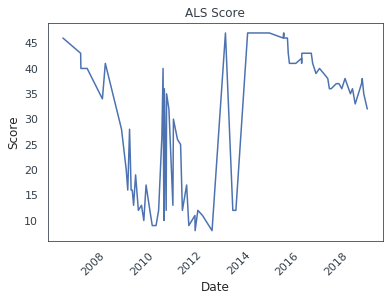

In [477]:
def line_plot(df,x,y):
    name =[x for x in globals() if globals()[x] is df][0]
    temp1=df.groupby([x]).mean().sort_values(by=[x,y]).reset_index()
    plt.plot(temp1[x],temp1[y])
    plt.title('ALS Score')
    plt.xlabel('Date') 
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.savefig(name+'.png')
line_plot(tts1,'report_date','score')

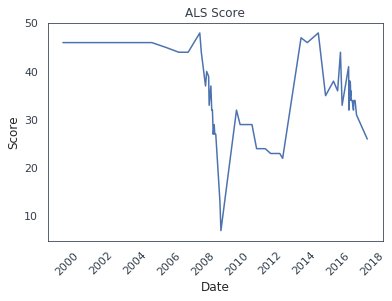

In [478]:
line_plot(tts2,'report_date','score')

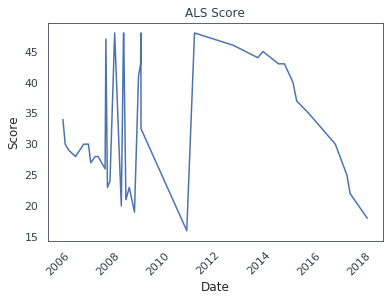

In [479]:
line_plot(tts3,'report_date','score')

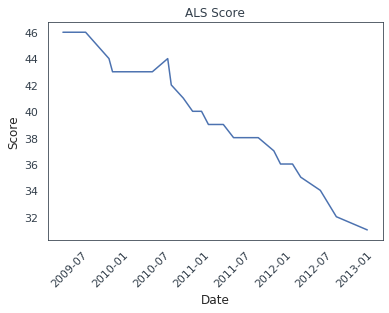

In [480]:
line_plot(tts4,'report_date','score')

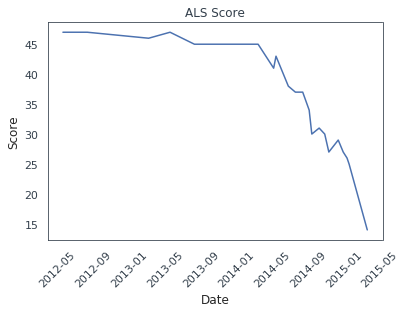

In [481]:
line_plot(tts5,'report_date','score')

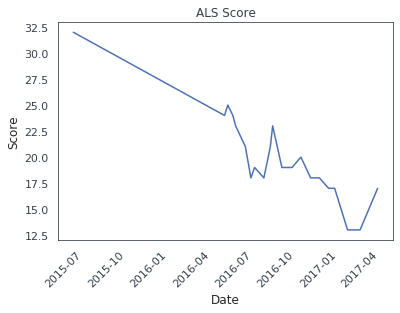

In [482]:
line_plot(tts6,'report_date','score')

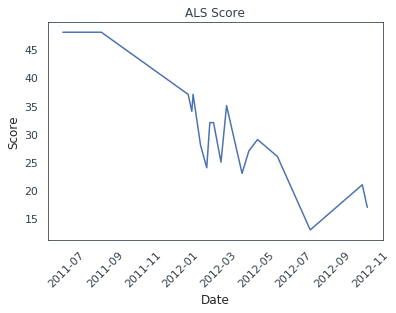

In [483]:
line_plot(tts7,'report_date','score')

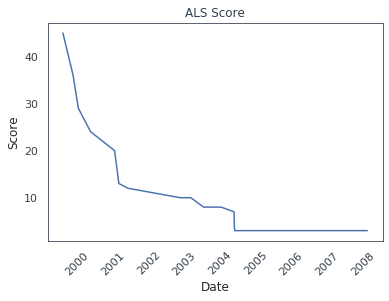

In [484]:
line_plot(tts8,'report_date','score')

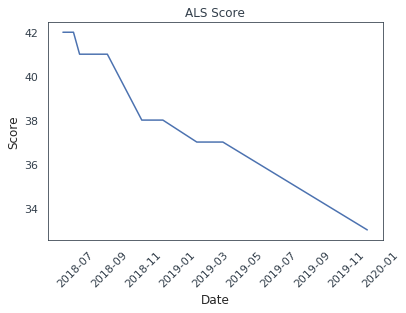

In [485]:
line_plot(tts9,'report_date','score')